In [7]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import numpy as np
import pandas as pd

def simulate_hirid_patient_realistic_with_missingness(seed=None):
    if seed is not None:
        np.random.seed(seed)

    # --- Time Setup ---
    duration_days = np.random.randint(1, 15)
    timesteps = duration_days * 24 * 12  # 5-min intervals
    time_index = np.arange(0, timesteps * 5, 5)

    # --- Signal Initialization ---
    heart_rate = np.random.normal(80, 10, timesteps)
    map_pressure = np.random.normal(75, 8, timesteps)
    respiratory_rate = np.random.normal(18, 3, timesteps)
    spo2 = np.random.normal(97, 2, timesteps)
    temperature = np.random.normal(37.0, 0.5, timesteps)
    lactate = np.random.normal(1.2, 0.4, timesteps)
    creatinine = np.random.normal(1.0, 0.3, timesteps)
    glucose = np.random.normal(110, 20, timesteps)
    vasopressor_rate = np.zeros(timesteps)
    mech_ventilation = np.zeros(timesteps)

    # --- Insert Shock Event (Safe) ---
    shock_start = np.random.randint(timesteps // 4, timesteps // 2)
    shock_duration = np.random.randint(100, 500)

    if shock_start + shock_duration > timesteps:
        shock_duration = timesteps - shock_start

    if shock_duration > 0:
        heart_rate[shock_start:shock_start+shock_duration] += np.random.normal(10, 3, shock_duration)
        map_pressure[shock_start:shock_start+shock_duration] -= np.random.normal(10, 3, shock_duration)
        lactate[shock_start:shock_start+shock_duration] += np.random.normal(2, 0.5, shock_duration)
        vasopressor_rate[shock_start:shock_start+shock_duration] = np.random.uniform(0.05, 0.2)

    # --- Insert Respiratory Failure (Safe) ---
    if np.random.rand() < 0.5 and timesteps > 1000:
        resp_failure_start = np.random.randint(timesteps // 2, timesteps - 500)
        resp_failure_duration = np.random.randint(100, 400)

        if resp_failure_start + resp_failure_duration > timesteps:
            resp_failure_duration = timesteps - resp_failure_start

        if resp_failure_duration > 0:
            spo2[resp_failure_start:resp_failure_start+resp_failure_duration] -= np.random.normal(10, 3, resp_failure_duration)
            respiratory_rate[resp_failure_start:resp_failure_start+resp_failure_duration] += np.random.normal(5, 2, resp_failure_duration)
            mech_ventilation[resp_failure_start:resp_failure_start+resp_failure_duration] = 1

    # --- Add Mild Drift ---
    drift = np.cumsum(np.random.normal(0, 0.01, timesteps))
    heart_rate += drift
    map_pressure += np.random.normal(0, 0.5, timesteps)
    respiratory_rate += np.random.normal(0, 0.5, timesteps)

    # --- Clamp to Realistic Ranges ---
    heart_rate = np.clip(heart_rate, 30, 200).astype(int)
    map_pressure = np.clip(map_pressure, 30, 130).astype(int)
    respiratory_rate = np.clip(respiratory_rate, 5, 50).astype(int)
    spo2 = np.clip(spo2, 70, 100).astype(int)
    temperature = np.clip(temperature, 35.0, 41.0)
    lactate = np.clip(lactate, 0.5, 15.0)
    creatinine = np.clip(creatinine, 0.2, 5.0)
    glucose = np.clip(glucose, 40, 400).astype(int)

    vasopressor_rate = np.round(vasopressor_rate, 3)
    mech_ventilation = mech_ventilation.astype(int)

    # --- Stack All Channels ---
    patient = np.stack([
        heart_rate,
        map_pressure,
        respiratory_rate,
        spo2,
        temperature,
        lactate,
        creatinine,
        glucose,
        vasopressor_rate,
        mech_ventilation
    ], axis=0)

    # --- Add Missingness (Realistic) ---
    # Random missing points
    missing_rate = np.random.uniform(0.05, 0.15)
    missing_mask = np.random.rand(*patient.shape) < missing_rate
    patient[missing_mask] = 0

    # Large block missingness
    if np.random.rand() < 0.1:
        for _ in range(np.random.randint(1, 3)):  # 1-2 blocks
            block_signal = np.random.randint(0, patient.shape[0])
            block_start = np.random.randint(0, max(1, patient.shape[1] - 200))
            block_length = np.random.randint(50, 200)
            patient[block_signal, block_start:block_start+block_length] = 0

    return patient


def simulate_hirid_dataset(save_dir, num_runs=10, patients_per_run=1000):
    os.makedirs(save_dir, exist_ok=True)

    for run_idx in range(num_runs):
        print(f'Generating run {run_idx+1}/{num_runs}...')
        patients = []
        labels = []  # Optional if you want to generate labels now

        for _ in tqdm(range(patients_per_run)):
            patient = simulate_hirid_patient_realistic_with_missingness()
            patients.append(patient)
            # For now no hard labels, but you could append here

        max_length = max([p.shape[1] for p in patients])

        # Pad all patients
        padded_patients = []
        for patient in patients:
            pad_width = max_length - patient.shape[1]
            if pad_width > 0:
                padded_patient = np.pad(patient, ((0,0), (0,pad_width)), 'constant')
            else:
                padded_patient = patient
            padded_patients.append(padded_patient)

        X_run = np.stack(padded_patients)

        run_folder = os.path.join(save_dir, f'run_{run_idx}')
        os.makedirs(run_folder, exist_ok=True)
        np.save(os.path.join(run_folder, 'X.npy'), X_run)
        print(f'Run {run_idx} saved with shape {X_run.shape}')


In [8]:
def load_synthetic_batches(base_path, runs_to_load=None):
    """
    base_path: path where all runs are saved
    runs_to_load: list of run indices [0, 1, 2] to load, None = load all
    """
    if runs_to_load is None:
        runs_to_load = [int(d.split('_')[1]) for d in os.listdir(base_path) if d.startswith('run_')]

    all_X = []

    for run_idx in runs_to_load:
        run_folder = os.path.join(base_path, f'run_{run_idx}')
        print(f'Loading run {run_idx} from {run_folder}')
        X_batch = np.load(os.path.join(run_folder, 'X.npy'))
        all_X.append(X_batch)

    X_full = np.concatenate(all_X, axis=0)
    print(f'Total shape after loading: {X_full.shape}')
    return X_full


In [9]:
# Generate 10x1000 synthetic ICU patients
simulate_hirid_dataset('/content/drive/MyDrive/TRACE_SYNTHETIC_FULL/', num_runs=10, patients_per_run=1000)

# Later: Load first 2 runs
X_data = load_synthetic_batches('/content/drive/MyDrive/TRACE_SYNTHETIC_FULL/', runs_to_load=[0,1])

print(X_data.shape)  # Should be (2000, 10, max_timesteps)


Generating run 1/10...


100%|██████████| 1000/1000 [00:01<00:00, 522.92it/s]


Run 0 saved with shape (1000, 10, 4032)
Generating run 2/10...


100%|██████████| 1000/1000 [00:01<00:00, 590.28it/s]


Run 1 saved with shape (1000, 10, 4032)
Generating run 3/10...


100%|██████████| 1000/1000 [00:01<00:00, 609.33it/s]


Run 2 saved with shape (1000, 10, 4032)
Generating run 4/10...


100%|██████████| 1000/1000 [00:01<00:00, 617.76it/s]


Run 3 saved with shape (1000, 10, 4032)
Generating run 5/10...


100%|██████████| 1000/1000 [00:01<00:00, 613.42it/s]


Run 4 saved with shape (1000, 10, 4032)
Generating run 6/10...


100%|██████████| 1000/1000 [00:01<00:00, 612.41it/s]


Run 5 saved with shape (1000, 10, 4032)
Generating run 7/10...


100%|██████████| 1000/1000 [00:01<00:00, 610.74it/s]


Run 6 saved with shape (1000, 10, 4032)
Generating run 8/10...


100%|██████████| 1000/1000 [00:01<00:00, 630.69it/s]


Run 7 saved with shape (1000, 10, 4032)
Generating run 9/10...


100%|██████████| 1000/1000 [00:02<00:00, 433.52it/s]


Run 8 saved with shape (1000, 10, 4032)
Generating run 10/10...


100%|██████████| 1000/1000 [00:01<00:00, 618.43it/s]


Run 9 saved with shape (1000, 10, 4032)
Loading run 0 from /content/drive/MyDrive/TRACE_SYNTHETIC_FULL/run_0
Loading run 1 from /content/drive/MyDrive/TRACE_SYNTHETIC_FULL/run_1
Total shape after loading: (2000, 10, 4032)
(2000, 10, 4032)


In [10]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

class RichSyntheticICUDataset(Dataset):
    def __init__(self, data_folder):
        """
        data_folder: Folder containing 'X.npy' for one run
        """
        self.X = np.load(os.path.join(data_folder, 'X.npy'))
        self.X = torch.tensor(self.X, dtype=torch.float32)  # [num_patients, channels, timesteps]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]  # Only return X for now (no labels needed)


In [11]:
import torch.nn as nn

class TRACEEncoderMasked(nn.Module):
    def __init__(self, input_channels=10, latent_dim=128):
        super(TRACEEncoderMasked, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Final global pooling over time
        )
        self.fc = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_channels)  # Predict back the input channels
        )

    def forward(self, x, mask=None):
        """
        x: [batch_size, channels, timesteps]
        mask: [batch_size, channels, timesteps] - binary (1=observed, 0=masked)
        """
        x_input = x.clone()

        if mask is not None:
            x_input = x_input * mask  # apply mask during training

        encoded = self.encoder(x_input)  # [batch_size, 128, 1]
        encoded = encoded.squeeze(-1)    # [batch_size, 128]
        latent = self.fc(encoded)         # [batch_size, latent_dim]

        reconstructed = self.decoder(latent)  # [batch_size, input_channels]

        return reconstructed, latent


In [12]:
def generate_random_mask(batch_shape, mask_ratio=0.15):
    """
    batch_shape: (batch_size, channels, timesteps)
    mask_ratio: float, % of elements to mask
    """
    batch_size, channels, timesteps = batch_shape
    mask = torch.ones(batch_size, channels, timesteps)

    num_total = channels * timesteps
    num_mask = int(mask_ratio * num_total)

    for b in range(batch_size):
        idx = torch.randperm(num_total)[:num_mask]
        coords = np.unravel_index(idx.numpy(), (channels, timesteps))
        mask[b, coords[0], coords[1]] = 0  # 0 = masked

    return mask


In [13]:
def masked_mse_loss(y_pred, y_true, mask):
    """
    y_pred: [batch_size, channels]
    y_true: [batch_size, channels]
    mask: [batch_size, channels, timesteps]
    """
    mask = (mask.sum(dim=2) > 0).float()  # Collapse time to feature presence
    loss = (mask * (y_pred - y_true)**2).sum() / (mask.sum() + 1e-6)
    return loss


In [14]:
def train_trace_masked_model(model, train_loader, num_epochs=20, lr=0.001, mask_ratio=0.15, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        count_batches = 0

        for batch in train_loader:
            X_batch = batch.to(device)  # [batch_size, channels, timesteps]

            # Generate random mask
            mask = generate_random_mask(X_batch.shape, mask_ratio=mask_ratio).to(device)

            # Forward pass
            reconstructed, _ = model(X_batch, mask)

            # Target: mean over timesteps
            X_target = X_batch.mean(dim=2)  # [batch_size, channels]

            # Compute masked loss
            loss = masked_mse_loss(reconstructed, X_target, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count_batches += 1

        avg_loss = total_loss / count_batches
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.6f}')

    print('Training finished!')
    return model


In [15]:
def extract_embeddings(model, data_loader, device='cuda'):
    model = model.to(device)
    model.eval()

    all_embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            X_batch = batch.to(device)
            _, latent = model(X_batch, mask=None)  # No masking during inference
            all_embeddings.append(latent.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)
    return all_embeddings


In [18]:
from torch.utils.data import DataLoader, Dataset

# Setup Dataset and Loader
data_path = '/content/drive/MyDrive/TRACE_SYNTHETIC_FULL/run_0/'
dataset = RichSyntheticICUDataset(data_path)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model
model = TRACEEncoderMasked(input_channels=10, latent_dim=128)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train
trained_model = train_trace_masked_model(model, train_loader, num_epochs=20, device=device)

# Extract Embeddings
embeddings = extract_embeddings(trained_model, train_loader, device=device)
print(f'Embeddings shape: {embeddings.shape}')


Epoch [1/20] Loss: 202.160843
Epoch [2/20] Loss: 3.484921
Epoch [3/20] Loss: 0.448437
Epoch [4/20] Loss: 0.328717
Epoch [5/20] Loss: 0.329233
Epoch [6/20] Loss: 0.323569
Epoch [7/20] Loss: 0.331046
Epoch [8/20] Loss: 0.292454
Epoch [9/20] Loss: 0.277877
Epoch [10/20] Loss: 0.273560
Epoch [11/20] Loss: 0.265423
Epoch [12/20] Loss: 0.253239
Epoch [13/20] Loss: 0.247214
Epoch [14/20] Loss: 0.232207
Epoch [15/20] Loss: 0.213722
Epoch [16/20] Loss: 0.187552
Epoch [17/20] Loss: 0.179721
Epoch [18/20] Loss: 0.165261
Epoch [19/20] Loss: 0.179245
Epoch [20/20] Loss: 0.170151
Training finished!
Embeddings shape: (1000, 128)


In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def plot_tsne(embeddings, labels=None):
    """
    embeddings: (num_samples, latent_dim)
    labels: optional, if you have ground-truth labels (for color-coding)
    """
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings_scaled)

    plt.figure(figsize=(10, 8))

    if labels is not None:
        for label in np.unique(labels):
            idx = labels == label
            plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Label {label}', alpha=0.6, s=10)
        plt.legend()
    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=10)

    plt.title('t-SNE projection of TRACE embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def simple_classifier_experiments(embeddings, num_classes=3):
    """
    embeddings: patient latent vectors
    For now we randomly generate fake labels for the purpose of testing pipeline
    (since we don't have ground-truth from synthetic data yet)
    """
    # Random labels (for now)
    np.random.seed(42)
    labels = np.random.randint(0, num_classes, size=embeddings.shape[0])

    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42, stratify=labels)

    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5)
    }

    results = {}

    for name, clf in classifiers.items():
        print(f'\nTraining {name}...')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {acc:.4f}')
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

        results[name] = acc

    print('\n=== Summary of Classifier Accuracies ===')
    for name, acc in results.items():
        print(f'{name}: {acc:.4f}')


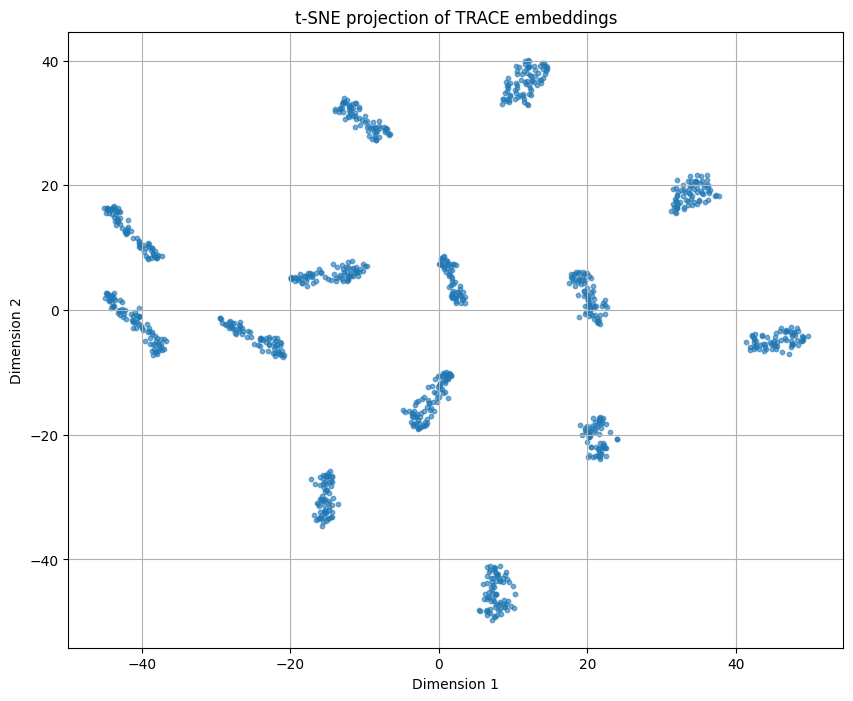


Training Logistic Regression...
Accuracy: 0.3933
Confusion Matrix:
[[59 22 25]
 [50 30 18]
 [45 22 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.56      0.45       106
           1       0.41      0.31      0.35        98
           2       0.40      0.30      0.35        96

    accuracy                           0.39       300
   macro avg       0.40      0.39      0.38       300
weighted avg       0.40      0.39      0.38       300


Training Random Forest...
Accuracy: 0.3333
Confusion Matrix:
[[44 30 32]
 [37 30 31]
 [42 28 26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.42      0.38       106
           1       0.34      0.31      0.32        98
           2       0.29      0.27      0.28        96

    accuracy                           0.33       300
   macro avg       0.33      0.33      0.33       300
weighted avg       0.33      0.33      0.33

In [21]:
plot_tsne(embeddings)
simple_classifier_experiments(embeddings, num_classes=3)
